In [106]:
import pandas
import pathlib
import re
import numpy as np
# import plotly.graph_objects as go
import datetime
from matplotlib import pyplot as plt
import json
from typing import Tuple

cwd = pathlib.Path.cwd()

G = 6.67408e-11
SCALE = 20
YEARS = 5
h = 60*60*24/SCALE  # number of seconds in a day
tsteps = 365*YEARS*SCALE  # number of days
X = 0
Y = 1


Classes

In [107]:
class Wanderer():
    '''
    Yes there are a number of variables that with Python I can easily access, but I made them private
    with methods to get ahold of them for purposes of 1) clarity and 2) safty. I don't want to accidentally
    access a variable, 
    '''
    def __init__(self, name: str, mass: float, x0: float, y0: float, vx0: float, vy0: float) -> None:

        self._name = name
        self._mass = mass
        self.rn = np.array([[x0, y0]])
        self.vn = np.array([[vx0, vy0]])
        self.clear_drdv()

        self._store_dv = np.zeros(shape = (1, 2))
        self._store_dr = np.zeros(shape = (1, 2))

    
    def clear_drdv(self):
        '''
        Clears the dr/dt and dv/dt values, making them all zero: that way, for the NBodies class, the same vel and acc
        script can be called over and over again without any realy modificatin: dv/dt and dr/dt are 0 so dv/dt = v + 
        '''
        self._dr = np.zeros(shape = (4, 2))
        self._dv = np.zeros(shape = (4, 2))

    
    def store_drdv(self, dr: np.array, dv: np.array):
        '''
        Stores a dv/dt and dr/dt value for later updating
        '''
        self._store_dr = dr
        self._store_dv = dv


    def update_drdv(self, k: int):
        '''
        Takes whatever is in storage and saves it to a position.
        '''
        self._dr[k] = self._store_dr
        self._dv[k] = self._store_dv

    
    def GMass(self, G):
        '''
        creates a new attribute, gass, which is just Mass * G. Useful instead of doing G*self._mass over and over again
        '''
        self.gass = self._mass * G


    def get_drdv(self) -> Tuple[np.array, np.array]:
        '''
        Just returns the dr and dv attributes.
        '''
        return self._dr, self._dv
    

    def get_kth(self, k: int) -> Tuple[np.array, np.array]:
        '''
        Returns the dr and dk values at a given k.
        '''
        return self._dr[k], self._dv[k]
    

    def update_rnvn(self, rn, vn):
        '''
        Adds the next iteration to the position and velocity array
        '''
        self.rn = np.vstack([self.rn, rn])
        self.vn = np.vstack([self.vn, vn])

    
    def time_step(self, t = 60*60*24):
        '''
        Sets the time step for the body. Instead of using the time step for every single 
        '''
        self.h = t


In [108]:
class NBodies():
    '''
    '''
    def __init__(self, system:tuple, tsteps: int, h: float, G: float) -> None:

        self.system = system
        self.tsteps = tsteps
        self.h = h
        self.G = G


    def orbits(self):
        '''
        '''
        body: Wanderer

        for body in self.system:
            body.GMass(self.G)

        for t in range(self.tsteps):
            self.time_step(t)
            self.n_plusone(t)


    def time_step(self, t: int):
        '''
        '''
        body: Wanderer
        jody: Wanderer

        for k_iter in range(4):
            kn: int = k_iter - 1
            if (kn < 0):
                kn = 0  # the k values for a given body are set to 0, so indexing with kn = 0 and k = 0 means the return values are 0.
                        # it's a little bit of work to be super lazy: I can use the same function over and over with no alteration, just
                        # need to make sure that the tables are set to 0 at the start of the loop

            for body in self.system:
                if body._name in "Sun":
                    body.update_rnvn(body.rn[0], body.vn[0])  # if it's the sun, just keep it's position at 0
                else:
                    Janders = []

                    for jody in self.system:
                        if body._name not in jody._name:
                            Janders.append(jody)

                    Janders = tuple(Janders)

                    local_dr = self.vel(body, t, kn)
                    local_dv = self.acc(body, Janders, t, kn)
                    body.store_drdv(local_dr, local_dv)

                    # print(f"kn = {kn}, Local dr = {local_dr}, local dv = {local_dv}")
            
            for body in self.system:
                if body._name not in "Sun":
                    body.update_drdv(k_iter)
    

    def n_plusone(self, n: int):
        '''
        '''
        body: Wanderer
        for body in self.system:
            rn:np.array = body.rn[n]
            vn:np.array = body.vn[n]

            dr, dv = body.get_drdv()

            rnn: np.array = rn + (self.h / 6.0) * (dr[0] + 2*dr[1] + 2*dr[2] + dr[3])
            vnn: np.array = vn + (self.h / 6.0) * (dv[0] + 2*dv[1] + 2*dv[2] + dv[3])

            body.update_rnvn(rnn, vnn)

            body.clear_drdv()



    def vel(self, iWander: Wanderer, n: int, k: int):
        '''
        Yields the dr/dt = k value

        dr/dt = v + (dv/dt)*h
        '''
        vn: np.array
        dv: np.array

        h: float = self.h if ((k == 0) or (k == 3)) else (self.h/2)

        vn = iWander.vn[n]
        _, dv = iWander.get_kth(k)

        return vn + (dv*h)




    def acc(self, iWander: Wanderer, jWanders: tuple, n: int, k: int) -> np.array:
        '''
        Yields the dv/dt = k value

        dv/dt = -G Sum[ Mj * (ri + (dri*h) - rj)/(ri + (dri*h) - rj)**3]
        '''
        dri: np.array
        drj: np.array
        kn: np.array = np.zeros(shape = (2,))

        h = self.h if ((k == 0) or (k == 3)) else (self.h/2)

        ri: np.array = iWander.rn[n]
        dri, _ = iWander.get_kth(k)

        ri = ri + dri*h

        jody: Wanderer
        for jody in jWanders:
            rj: np.array = jody.rn[n]
            drj, _ = jody.get_kth(k)

            rj = rj + drj*h

            r: float = np.sqrt(np.dot(ri - rj, ri - rj))
            a: float = (-1) * jody.gass / (r**3)

            kn += a * (ri - rj)

        return kn



Other methods

In [109]:
def import_bodies() -> tuple:
    '''
    Reads the AstronomicalObjects.json and establishes a Wanderer object for each of them.
    '''
    with open(cwd / "AstronomicalObjects.json", 'r') as json_file:
        system = []

        json_data = json.load(json_file)

        system_data = json_data["System"]

        for _, obj in system_data.items():
            body = Wanderer(obj["name"], obj["m"], obj["x0"], obj["y0"], obj["vx0"], obj["vy0"])

            system.append(body)

        return tuple(system)

def write_csv():
    '''
    '''

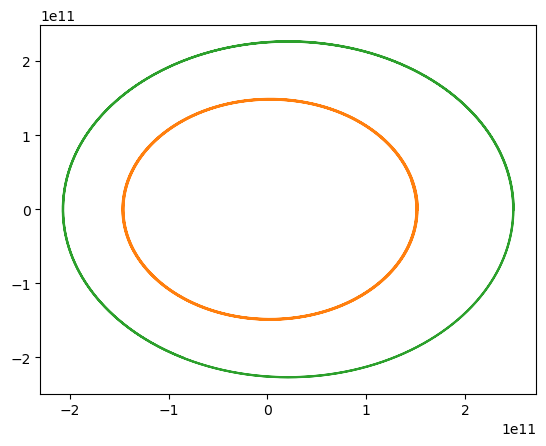

In [110]:
system = import_bodies()
nbodies = NBodies(system, tsteps, h, G)
nbodies.orbits()

# test_body: Wanderer
# test_body = system[1]
# print(test_body._name)
# print(test_body.rn)
# print(test_body.rn[:, 0])
# Need to reogranize the shape of the arrays: that way I can just pull [X] and [Y] to get a single column

for body in system:
    plt.plot(body.rn[:, X], body.rn[:, Y])

plt.show()
